In [1]:
import scperturb as scp 
import urllib.request
import os
import scanpy as sc 
import numpy as np
from matplotlib import pyplot as plt
from gsnn_lib.proc import omnipath 
import pandas as pd
import torch

from gsnn.models.GSNN import GSNN 
from gsnn.models.NN import NN
from hnet.models.HyperNet import HyperNet

from gsnn_lib.proc.sc.load import get_SrivatsanTrapnell2020, load_scp_dataset
from gsnn_lib.data.scSampler import scSampler

from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score

from hnet.train.hnet import init_hnet

import umap
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import gc 
from scipy.stats import ks_2samp, mannwhitneyu

from gsnn.ot.utils import plot_transport_plan, eval

from gsnn.ot.mmd import compute_scalar_mmd

%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_res_dict(res_dict, axes=None, window=10, label=''): 

    xx = np.arange(window//2, len(res_dict['mmds']) - window//2 + 1)

    if axes is None: f, axes = plt.subplots(1, 4, figsize=(12, 3))
    axes[0].plot(res_dict['mmds'], label=label)
    running_mean = np.convolve(res_dict['mmds'], np.ones(window)/window, mode='valid')
    axes[0].plot(xx, running_mean)
    axes[0].set_title('MMD')
    axes[0].legend()

    axes[1].plot(res_dict['shds'], label=label)
    running_mean = np.convolve(res_dict['shds'], np.ones(window)/window, mode='valid')
    axes[1].plot(xx, running_mean)
    axes[1].set_title('SHD')
    axes[1].legend()

    axes[2].plot(res_dict['wass'], label=label)
    running_mean = np.convolve(res_dict['wass'], np.ones(window)/window, mode='valid')
    axes[2].plot(xx, running_mean)
    axes[2].set_title('WASS')
    axes[2].legend()

    axes[3].plot(res_dict['mu_r2'], label=label)
    running_mean = np.convolve(res_dict['mu_r2'], np.ones(window)/window, mode='valid')
    axes[3].plot(xx, running_mean)
    axes[3].set_title('feature means r2 (delta)')
    axes[3].legend()

    if axes is None: plt.tight_layout()
    if axes is None: plt.show()

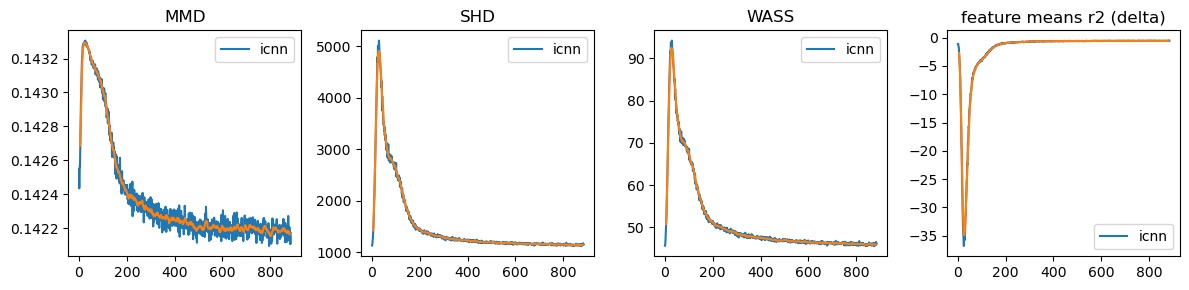

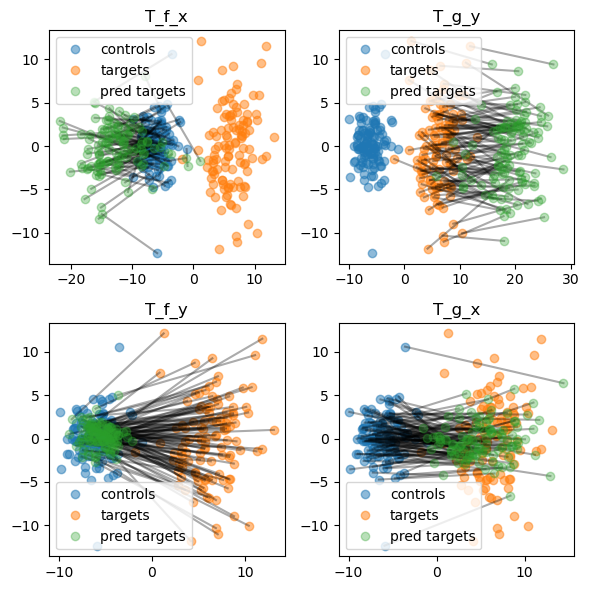

T g x ... R2: 0.9240851998329163
T f x ... R2: -11.628186225891113

T g x ... r: 0.9614530031086743
T f x ... r: -0.1576555666233986

T g x ... mse: 0.01577737368643284
T f x ... mse: 2.624516248703003

T g x ... mmd: 0.04503304678170631
T f x ... mmd: 0.017807105984474183


In [255]:
cond_idx = 3 # 3, 18, 33
res_dict_icnn = torch.load('../sc_output_icnn/res_dict.pt')

f, axes = plt.subplots(1, 4, figsize=(12, 3))
try: 
    plot_res_dict(res_dict_icnn, axes=axes, window=10, label='icnn')
except: 
    pass # fails if fewer than `window` iterations
plt.tight_layout()
plt.show()

Y = res_dict_icnn['sampler'].sample_targets(cond_idx, batch_size=500).cuda()
X = res_dict_icnn['sampler'].sample_controls(cond_idx, batch_size=Y.size(0)).cuda()
f = res_dict_icnn['f_dict'][cond_idx]
g = res_dict_icnn['g_dict'][cond_idx]
X.requires_grad_(True)
Y.requires_grad_(True)

vae = res_dict_icnn['T'].vae

pca = PCA(n_components=2)
pca.fit(np.concatenate([X.detach().cpu().numpy(), Y.detach().cpu().numpy()], axis=0))
ux = pca.transform(X.detach().cpu().numpy())
uy = pca.transform(Y.detach().cpu().numpy())

T_f_x = vae.decode(f.transport(vae.encode(X)))
T_g_y = vae.decode(g.transport(vae.encode(Y)))
T_f_y = vae.decode(f.transport(vae.encode(Y)))
T_g_x = vae.decode(g.transport(vae.encode(X)))

uT_f_x = pca.transform(T_f_x.detach().cpu().numpy())
uT_g_y = pca.transform(T_g_y.detach().cpu().numpy())
uT_f_y = pca.transform(T_f_y.detach().cpu().numpy())
uT_g_x = pca.transform(T_g_x.detach().cpu().numpy())

f,axes = plt.subplots(2, 2, figsize=(6, 6))

for ax, (xx, yy), tit in zip(axes.flatten(), [(ux, uT_f_x), (uy, uT_g_y), (uy, uT_f_y), (ux, uT_g_x)], ['T_f_x', 'T_g_y', 'T_f_y', 'T_g_x']):
    
    ax.plot(ux[:, 0], ux[:, 1], 'o', label='controls', alpha=0.5)
    ax.plot(uy[:, 0], uy[:, 1], 'o', label='targets', alpha=0.5)
    for i in range(uT_f_x.shape[0]):
        ax.plot([xx[i, 0], yy[i, 0]], [xx[i,1], yy[i, 1]], 'k-', alpha=0.33)
    ax.plot(yy[:, 0], yy[:, 1], 'o', label='pred targets', alpha=0.33)
    ax.legend()
    ax.set_title(tit)
plt.tight_layout()
plt.show()

deltahat = T_g_x.mean(0) - X.mean(0) 
deltahat2 = T_f_x.mean(0) - X.mean(0) 
delta = Y.mean(0) - X.mean(0)
print('T g x ... R2:', r2_score(delta.detach().cpu().numpy(), deltahat.detach().cpu().numpy()))
print('T f x ... R2:', r2_score(delta.detach().cpu().numpy(), deltahat2.detach().cpu().numpy()))
print()
print('T g x ... r:', np.corrcoef(delta.detach().cpu().numpy(), deltahat.detach().cpu().numpy())[0,1])
print('T f x ... r:', np.corrcoef(delta.detach().cpu().numpy(), deltahat2.detach().cpu().numpy())[0,1])
print()
print('T g x ... mse:', torch.mean((delta - deltahat)**2).item())
print('T f x ... mse:', torch.mean((delta - deltahat2)**2).item())
print()
mmd = compute_scalar_mmd(Y.detach().cpu().numpy(), T_g_x.detach().cpu().numpy())
mmd2 = compute_scalar_mmd(Y.detach().cpu().numpy(), T_f_x.detach().cpu().numpy())
print('T g x ... mmd:', mmd)
print('T f x ... mmd:', mmd2)


In [242]:
res_dict_gsnn = torch.load('../sc_output3/res_dict.pt')                                                  
#res_dict_nn = torch.load('../sc_output_nn/res_dict.pt')
#res_dict_icnn = torch.load('../sc_output_icnn/res_dict.pt')
data = torch.load('../sc_data/' + 'data.pt')


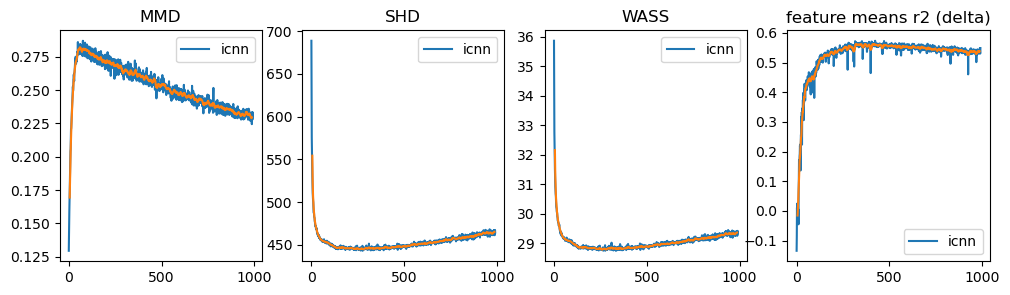

In [243]:
plot_res_dict(res_dict_gsnn, axes=None, window=10, label='icnn')

In [ ]:
f, axes = plt.subplots(1, 4, figsize=(12, 3))
plot_res_dict(res_dict_gsnn, axes=axes, window=10, label='gsnn')
plot_res_dict(res_dict_nn, axes=axes, window=10, label='nn')
plt.tight_layout()
plt.show()

In [256]:
mmds_gsnn, shds_gsnn, wass_gsnn, mu_r2_gsnn = eval(res_dict_gsnn['T'], res_dict_gsnn['sampler'], batch_size=32, partition='test', agg='none', max_n=500)
mmds_nn, shds_nn, wass_nn, mu_r2_nn = eval(res_dict_icnn['T'], res_dict_icnn['sampler'], batch_size=32, partition='test', agg='none', max_n=500)

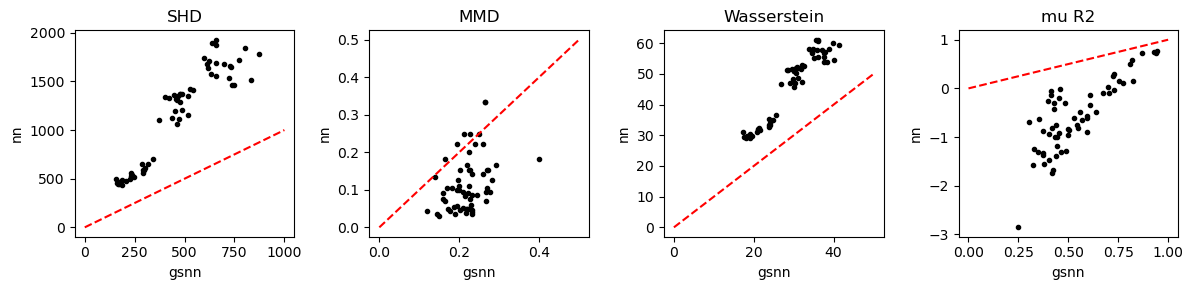

In [257]:
f,axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].plot(shds_gsnn, shds_nn, 'k.') 
axes[0].plot([0, 1000], [0, 1000], 'r--')
axes[0].set_xlabel('gsnn')
axes[0].set_ylabel('nn')
axes[0].set_title('SHD')

axes[1].plot(mmds_gsnn, mmds_nn, 'k.') 
axes[1].plot([0, 0.5], [0, 0.5], 'r--')
axes[1].set_xlabel('gsnn')
axes[1].set_ylabel('nn')
axes[1].set_title('MMD')

axes[2].plot(wass_gsnn, wass_nn, 'k.') 
axes[2].plot([0, 50], [0, 50], 'r--')
axes[2].set_xlabel('gsnn')
axes[2].set_ylabel('nn')
axes[2].set_title('Wasserstein')

axes[3].plot(mu_r2_gsnn, mu_r2_nn, 'k.') 
axes[3].plot([0, 1], [0, 1], 'r--')
axes[3].set_xlabel('gsnn')
axes[3].set_ylabel('nn')
axes[3].set_title('mu R2')

plt.tight_layout()
plt.show()

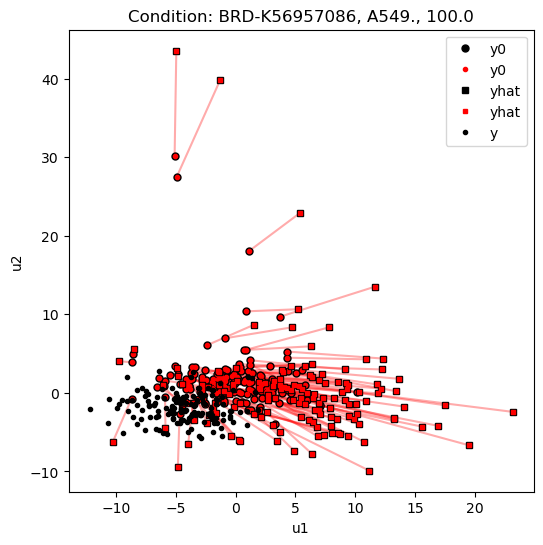

IndexError: single positional indexer is out-of-bounds

In [245]:
plot_transport_plan(res_dict_icnn['sampler'], res_dict_icnn['T'], F=None, conditions=[3,18,33], dim_red='pca', max_n=1000)

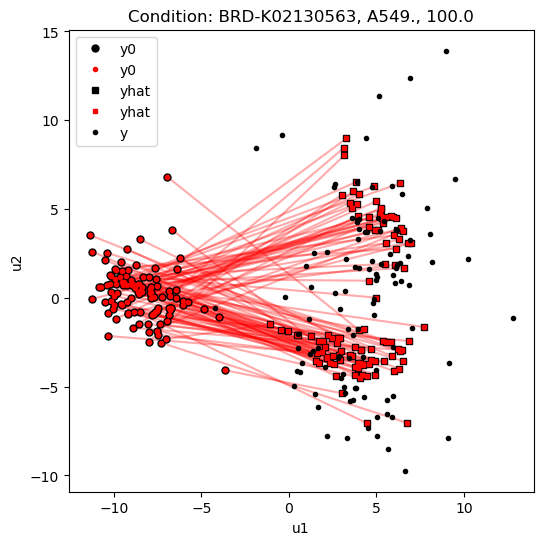

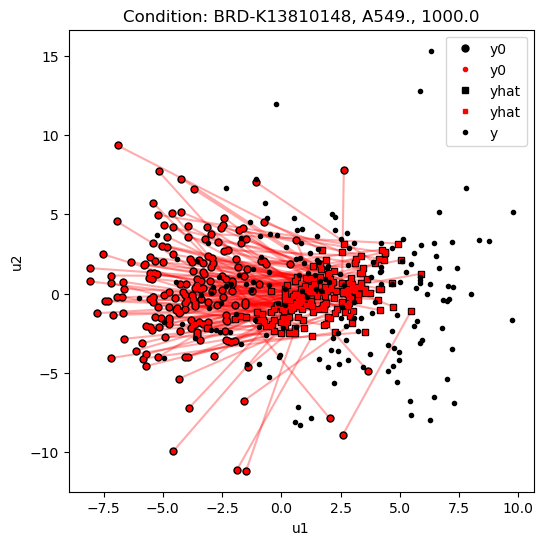

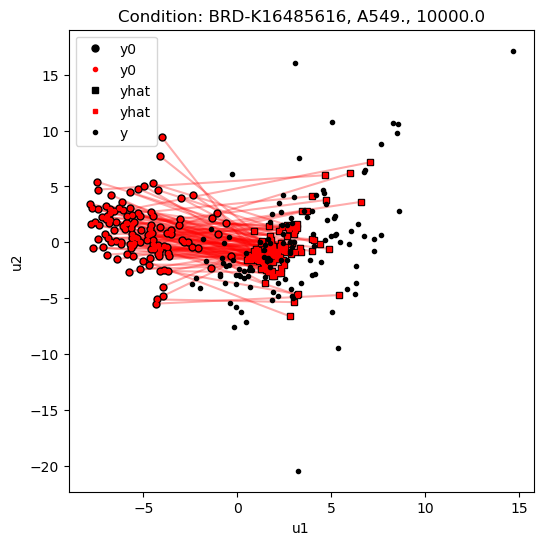

In [34]:
plot_transport_plan(sampler, res_dict_gsnn['T'], F=F, conditions=[3,18,33], dim_red='pca', max_n=1000)

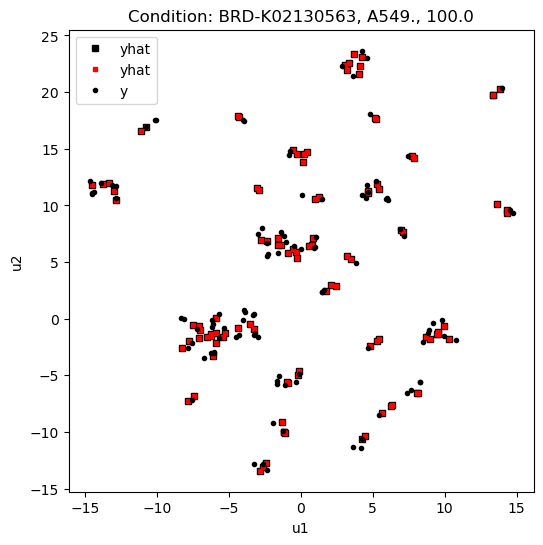

In [38]:
plot_transport_plan(sampler, res_dict_gsnn['T'], F=F, conditions=[3], dim_red='umap', max_n=1000, plot_y0=False)

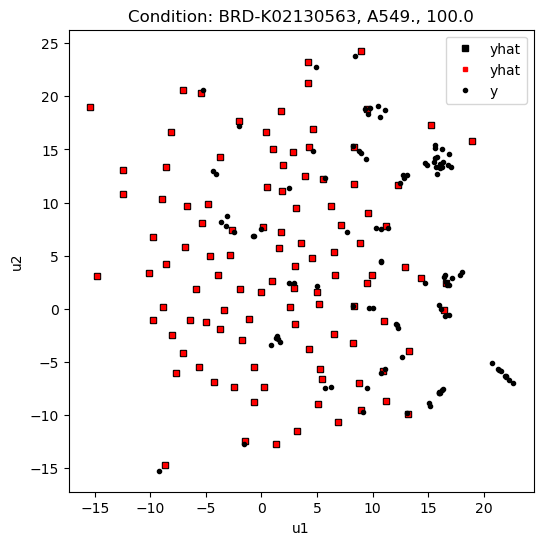

In [37]:
plot_transport_plan(sampler, res_dict_nn['T'], F=F, conditions=[3], dim_red='umap', max_n=1000, plot_y0=False)

In [58]:
def plot_all_conditions(sampler, T, max_n=500, batch_size=32):
    ''' 
    ''' 
    ys = [] 
    yhats = []
    for i in range(len(sampler)): 
        print(f'condition {i}/{len(sampler)}', end='\r')

        X,y, x_cell, x_drug, y0 = sampler.sample_(i, batch_size=max_n, ret_all_y=True)
        X = X.to(device); y=y.to(device); x_cell = x_cell.to(device); x_drug = x_drug.to(device); y0 = y0.to(device)
        
        for idx in torch.split(torch.arange(X.size(0)), batch_size): 
            with torch.no_grad(): 
                yhats.append(T(X[idx]) + y0[idx])
                ys.append(y[idx]) 

    ys = torch.cat(ys).detach().cpu().numpy()
    yhats = torch.cat(yhats).detach().cpu().numpy() 

    umap_ = umap.UMAP(n_components=2, min_dist=0.5)
    uy = umap_.fit_transform(np.concatenate((ys, yhats)))
    uyhat = umap_.transform(yhats)

    mmd = compute_scalar_mmd(uy, uyhat)

    plt.figure(figsize=(8,8))
    plt.plot(uy[:,0], uy[:,1], 'k.', label='Y', alpha=0.2)
    plt.plot(uyhat[:,0], uyhat[:,1], 'r.', label='Yhat', alpha=0.1)
    plt.legend()
    plt.xlabel('U0')
    plt.ylabel('U1')
    plt.show()

    return mmd

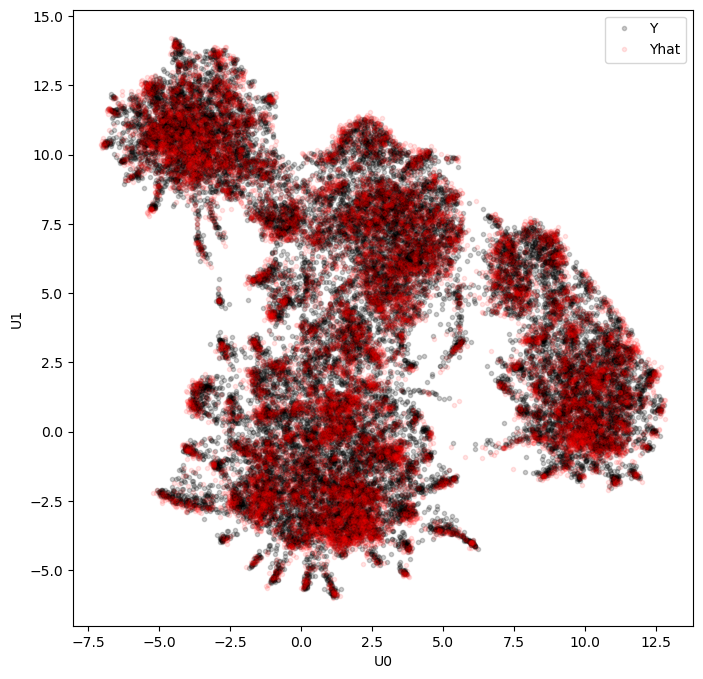

In [59]:
gsnn_umap_mmd = plot_all_conditions(sampler, res_dict_gsnn['T'], max_n=1000, batch_size=32)

In [60]:
gsnn_umap_mmd

0.0003897976130247116

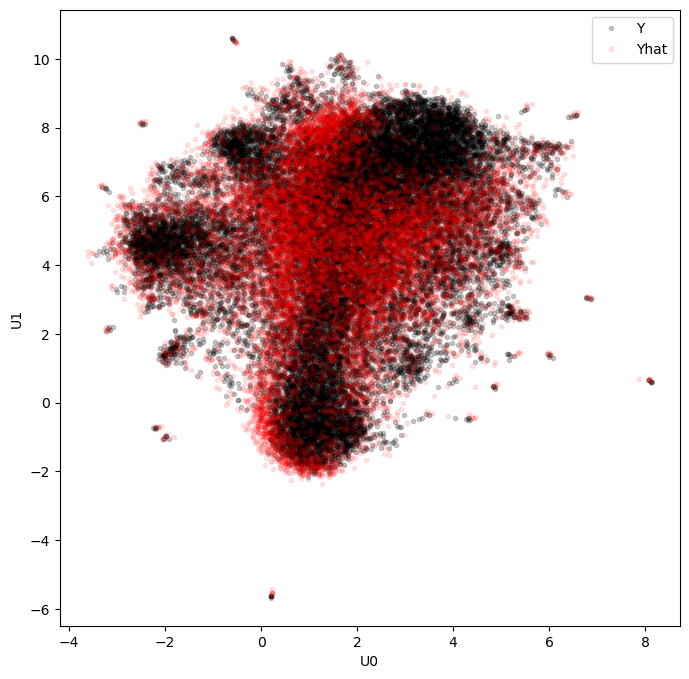

0.012322595963875452


In [61]:
nn_umap_mmd = plot_all_conditions(sampler, res_dict_nn['T'], max_n=1000, batch_size=32)
print(nn_umap_mmd)

In [252]:
mmds_, shds_, wass_, mu_r2 = eval(res_dict_icnn['T'], res_dict_icnn['sampler'], batch_size=32, partition='test', agg='none', max_n=None)

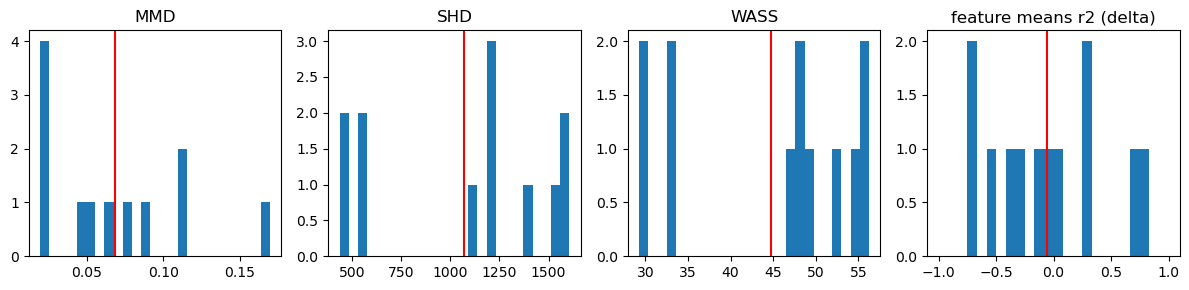

In [253]:
_bins = 25
f, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].hist(mmds_, bins=_bins)
axes[0].axvline(np.mean(mmds_), color='r')
axes[0].set_title('MMD')
axes[1].hist(shds_, bins=_bins)
axes[1].axvline(np.mean(shds_), color='r')
axes[1].set_title('SHD')
axes[2].hist(wass_, bins=_bins)
axes[2].axvline(np.mean(wass_), color='r')
axes[2].set_title('WASS')
axes[3].hist(mu_r2, bins=np.linspace(-1,1,_bins))
axes[3].axvline(np.mean(mu_r2), color='r')
axes[3].set_title('feature means r2 (delta)')
plt.tight_layout()
plt.show()

4